In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from itertools import combinations, permutations
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import scipy.io as sio

import raw_dataloader as dl
from scale_target import TargetScaler
import preprocessing
import add_features
import bandpower

# Analyze solution latency across subject and across difficulty level

In [2]:
SLs_all = {}

# Get list of data names
df_names = pd.read_csv('./Data_Matlab/data_list.csv')
data_names = [x[0:6] for x in df_names.values.flatten()]
data_names = [data_names[i] for i in range(11)]

# Get SL of each subject of each difficulty level
for i_data, data_name in enumerate(data_names):
    SLs_one = []
    for i_diff in range(1,4):
        X, Y_reg, _, S = dl.read_data([i_diff], [i_data], channel_limit=21, rm_baseline=True)
        SLs_one.append(Y_reg)
    SLs_all[data_name] = SLs_one



After removing trials longer than 60s, X shape:  (19, 21, 512)
Arrange all the channels as the same order

After removing trials longer than 60s, X shape:  (31, 21, 512)
Arrange all the channels as the same order

After removing trials longer than 60s, X shape:  (9, 21, 512)
Arrange all the channels as the same order

After removing trials longer than 60s, X shape:  (24, 21, 512)
Arrange all the channels as the same order

After removing trials longer than 60s, X shape:  (34, 21, 512)
Arrange all the channels as the same order

After removing trials longer than 60s, X shape:  (12, 21, 512)
Arrange all the channels as the same order

After removing trials longer than 60s, X shape:  (45, 21, 512)
Arrange all the channels as the same order

After removing trials longer than 60s, X shape:  (88, 21, 512)
Arrange all the channels as the same order

After removing trials longer than 60s, X shape:  (41, 21, 512)
Arrange all the channels as the same order

After removing trials longer than 60s,

Diff 1: mean (6.846346), number (322)
Diff 2: mean (10.682890), number (522)
Diff 3: mean (14.854026), number (195)


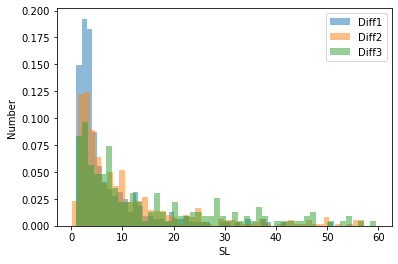

In [50]:
# Analyze across difficulty level
mean_SLs_diff = []
SLs_diff = [np.array([]) for i in range(3)]
diff_arr = np.array([])
fig, axs = plt.subplots()
for i_diff in range(3):
    SL, num_trial = 0, 0
    for data_name in data_names:
        SL += np.sum(SLs_all[data_name][i_diff])
        SLs_diff[i_diff] = np.hstack((SLs_diff[i_diff], SLs_all[data_name][i_diff]))
        num_trial += len(SLs_all[data_name][i_diff])
        
    diff_arr = np.hstack((diff_arr, np.zeros(num_trial)+i_diff))
    mean_SLs_diff.append(SL/num_trial)
    print('Diff %i: mean (%f), number (%i)'%(i_diff+1, mean_SLs_diff[i_diff], num_trial))
    plt.hist(SLs_diff[i_diff], bins=50, alpha=0.5, label='Diff%d'%(i_diff+1), density=True)
    
plt.xlabel('SL')
plt.ylabel('Number')
plt.legend(loc='upper right')

Subject 110411: mean (14.760196), number (59), range (52.918)
Subject 110414: mean (12.130804), number (70), range (48.641)
Subject 110714: mean (4.753053), number (174), range (52.922)
Subject 110715: mean (6.996578), number (137), range (45.043)
Subject 110721: mean (19.711573), number (43), range (54.160)
Subject 110728: mean (10.580078), number (94), range (54.371)
Subject 110729: mean (7.853411), number (112), range (46.824)
Subject 110816: mean (14.219661), number (60), range (52.723)
Subject 110822: mean (9.338474), number (154), range (51.770)
Subject 110929: mean (14.463937), number (56), range (54.695)
Subject 110930: mean (16.862061), number (80), range (57.074)


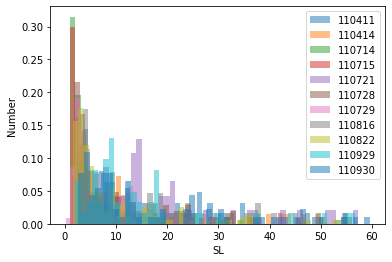

In [39]:
# Analyze across subject
SLs_sub = []
fig, axs = plt.subplots()
for data_name in data_names:
    SL_diff = []
    
    for i_diff in range(3):
        SL_diff += list(SLs_all[data_name][i_diff])
        
    SL_diff = np.array(SL_diff)
    SLs_sub.append(SL_diff)
    print('Subject %s: mean (%f), number (%i), range (%.3f)'
          %(data_name, np.mean(SL_diff), len(SL_diff), np.max(SL_diff)-np.min(SL_diff)))
    plt.hist(SL_diff, bins=50, alpha=0.5, label=data_name, density=True)
    
    '''
    plt.plot(np.sort(SL_diff))
    plt.title('Subect '+data_name)
    plt.savefig('./results/Analysis/SLs_sub%s.png'%(data_name))
    plt.close()
    '''
plt.xlabel('SL')
plt.ylabel('Number')
plt.legend(loc='upper right')

Accross diff:  KruskalResult(statistic=52.79035320957894, pvalue=3.4412834961356324e-12)


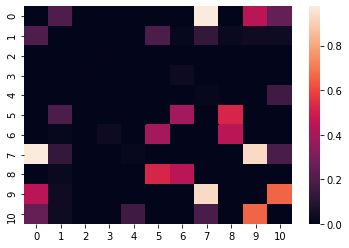

In [76]:
# Kruskal-Wallis H-test across difficulty
for i in range(3):
    np.random.shuffle(SLs_diff[i])
min_len = min([len(SLs_diff[i]) for i in range(3)])
result_diff = stats.kruskal(SLs_diff[0][:min_len], SLs_diff[1][:min_len], SLs_diff[2][:min_len])
print('Accross diff: ', result_diff)

# Kruskal-Wallis H-test across subjects
for i in range(11):
    np.random.shuffle(SLs_sub[i])
p_array = np.zeros((11,11))
perm = permutations(range(11), 2)
for (sub1,sub2) in list(perm):
    min_len = min([len(SLs_sub[sub1]), len(SLs_sub[sub2])])
    result_sub = stats.kruskal(SLs_sub[sub1][:min_len], SLs_sub[sub2][:min_len])
    #print('Sub %d and %d: %s'%(sub1, sub2, result_sub))
    p_array[sub1,sub2] = result_sub.pvalue
    
ax = sns.heatmap(p_array)


# Make sure all the channel electrodes are in the same order

In [31]:
# Get list of data names
df_names = pd.read_csv('%s/Data_Matlab/data_list.csv'%(root_path))
data_names = [x[0:6] for x in df_names.values.flatten()]
data_names = [data_names[i] for i in range(11)]

# Load channel info
channel_info = {}
for data_name in data_names:
    channel_info[data_name] = pd.read_csv('./Channel_coordinate/%s_channels.csv'%(data_name))
    
# Compare every subject with the first subject
channel_order = np.zeros((128, 11))-1
arc_length_9 = channel_info[data_names[9]]['arc_length'].values
theta_9 = channel_info[data_names[9]]['theta'].values
for i in range(len(data_names)):
    if i == 9:
        continue
    channel_info_i = channel_info[data_names[i]]
    for i_channel in range(len(channel_info_i)):
        arc_length = channel_info_i['arc_length'][i_channel]
        theta = channel_info_i['theta'][i_channel]
        channel_order[i_channel, i] = np.argmin(arc_length_9**2+arc_length**2 \
                                                - 2*arc_length*arc_length_9*np.cos((theta_9-theta)*np.pi/180))
        

In [33]:
channel_order[:,0]

array([78., 42., 78., 42., 42., 78., 78., 42., 42., 42., 42., 78., 42.,
       42., 42., 42., 41., 42., 42., 42., 42., 42., 42., 42., 42., 42.,
       42., 42., 42., 42., 42., 42., 42., 42., 42., 42., 42., 42., 42.,
       42., 42., 42., 42., 42., 42., 42., 42., 42., 42., 42., 42., 42.,
       42., 42., 42., 42., 42., 42., 42., 42., 42., 42., 42., 42., 42.,
       42., 42., 42., 42., 42., 42., 42., 42., 42., 42., 42., 42., 42.,
       42., 42., 42., 42., 42., 42., 42., 42., 42., 42., 42., 42., 42.,
       42., 42., 42., 42., 42., 42., 42., 42., 42., 42., 42., 42., 42.,
       42., 42., 42., 42., 42., 42., 42., 42., 42., 42., 42., 42., 42.,
       42., 42., 42., 42., 42., 42., 42., 42., 42., 42., 42.])

# Analyze difference of scaling target normally and quantizationally

In [7]:
def plot_scatter(data, title):
    sort_indices = np.argsort(data)
    plt.plot(range(len(data)), data[sort_indices], marker='.')
    plt.title(title)
    
    '''
    fig, axs = plt.subplots(1,2, figsize=(8,4))
    axs[0].plot(range(len(true)), true[sort_indices], 'r.', range(len(true)), pred[sort_indices], 'b.')
    axs[0].set_xlabel('Record number')
    axs[0].set_ylabel('Solution latency')
    axs[0].legend(('True', 'Pred'))
    axs[0].set_title('std error = %.3f'%(mean_squared_error(true, pred)**0.5))

    max_value = np.max(np.hstack((true, pred)))
    axs[1].scatter(true, pred, marker='.')
    axs[1].plot(range(int(max_value)), range(int(max_value)), 'r')
    axs[1].set_xlabel('True')
    axs[1].set_ylabel('Pred')
    axs[1].set_xlim([0, max_value])
    axs[1].set_ylim([0, max_value])
    axs[1].set_title('r = %.3f'%(np.corrcoef(true, pred)[0,1]))
    '''

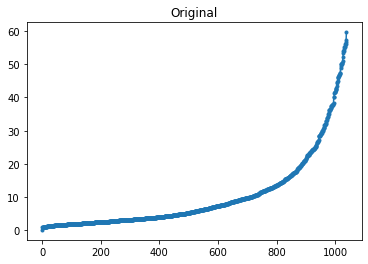

In [13]:
plot_scatter(SLs, 'Original')

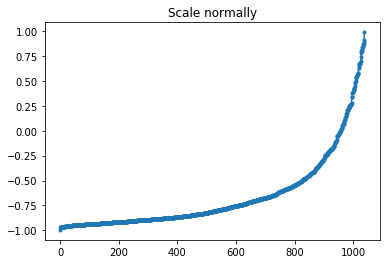

In [9]:
# Load data
with open('./raw_data/ERSP_from_raw_100_channel21.data', 'rb') as fp:
    dict_ERSP = pickle.load(fp)

SLs = dict_ERSP['SLs']

# Scale target to -1~1 normally
SLs_scale_nor = (SLs-30)/30
plot_scatter(SLs_scale_nor, 'Scale normally')

[-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]
[ 0.          1.859375    2.53203125  3.29296875  4.16484375  5.625
  7.79140625 10.53359375 15.3796875  25.275      60.        ]


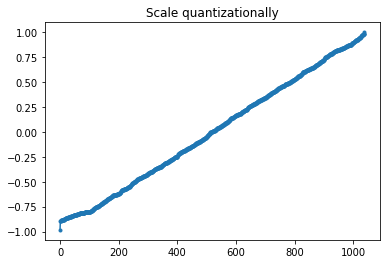

In [12]:
# Scale target to -1~1 quantizationally
scaler = TargetScaler(num_step=10)
scaler.fit(SLs)
SLs_scale_quan = scaler.transform(SLs, mode='normal')

plot_scatter(SLs_scale_quan, 'Scale quantizationally')

# Analyze distribution of bandpower ratio

In [4]:
X,Y,_,S,D = dl.read_data([1,2,3], range(11), channel_limit=21, rm_baseline=True)
low, high = [4,7,13], [7,13,30]
X = bandpower.get_bandpower(X, low=low, high=high)
X = add_features.get_bandpower_ratio(X)
X = X.flatten()
X_less = X[X<5]
print('Number of (X,X_less): (%d,%d)'%(len(X), len(X_less)))

After removing trials longer than 60s, X shape:  (1039, 21, 512)
Arrange all the channels as the same order

Calculating the bandpower of time-series data...
Calculate bandpower ratio...
BR: (468.814,0.002)
Number of (X,X_less): (4058334,3738984)


(array([1.10000e+01, 3.70000e+01, 1.60000e+02, 4.52000e+02, 1.33900e+03,
        3.31900e+03, 7.68100e+03, 1.80470e+04, 4.06850e+04, 8.21940e+04,
        1.50810e+05, 2.50361e+05, 3.75128e+05, 5.03932e+05, 5.95011e+05,
        5.95011e+05, 5.03932e+05, 3.75128e+05, 2.50361e+05, 1.50810e+05,
        8.21940e+04, 4.06850e+04, 1.80470e+04, 7.68100e+03, 3.31900e+03,
        1.33900e+03, 4.52000e+02, 1.60000e+02, 3.70000e+01, 1.10000e+01]),
 array([-6.15020627, -5.74019252, -5.33017877, -4.92016502, -4.51015127,
        -4.10013751, -3.69012376, -3.28011001, -2.87009626, -2.46008251,
        -2.05006876, -1.64005501, -1.23004125, -0.8200275 , -0.41001375,
         0.        ,  0.41001375,  0.8200275 ,  1.23004125,  1.64005501,
         2.05006876,  2.46008251,  2.87009626,  3.28011001,  3.69012376,
         4.10013751,  4.51015127,  4.92016502,  5.33017877,  5.74019252,
         6.15020627]),
 <BarContainer object of 30 artists>)

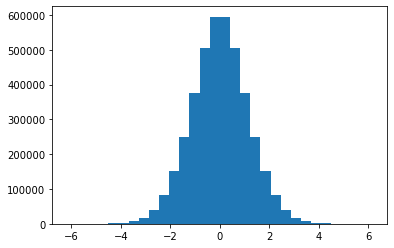

In [7]:
plt.hist(np.log(X), bins=30)

# Analyze SL subject under high stress (higher alpha\theta power in frontal and occipital region)

<font size='3'>
Claim1 (X): 

The subject under high stress (theta and alpha power (dB) are inversely proportional to SNR in frontal and occipital region) has longer solution latency.
    
Result:

The result doesn’t show this trend. There is not a consistent relationship between band power and solution latency for each subject.
</font>

In [2]:
X,Y,_,S,D = dl.read_data([1,2,3], range(11), channel_limit=21, rm_baseline=True)
low, high = [4,7], [7,13]    # theta, alpha, beta
bp_all = bandpower.get_bandpower(X, low=low, high=high)

After removing trials longer than 60s, X shape:  (1038, 21, 512)
Arrange all the channels as the same order

Calculating the bandpower of time-series data...


In [3]:
# Extract frontal and occipital index
channel_order = dl.read_channel_name(21)
frontal = {channel:i for i,channel in enumerate(['Fp1','Fp2','F3','Fz','F4'])}
occipital = {channel:i for i,channel in enumerate(['O1','Oz','O2'])}
frontal_index, occipital_index = np.zeros(len(frontal), dtype=int), np.zeros(len(occipital), dtype=int)

for i, channel in enumerate(channel_order):
    if channel in frontal:
        frontal_index[frontal[channel]] = i
    elif channel in occipital:
        occipital_index[occipital[channel]] = i 

frontal_bp, occipital_bp = {}, {}
frontal_bp['theta'], frontal_bp['alpha'] = bp_all[:,frontal_index,0], bp_all[:,frontal_index,1]
occipital_bp['theta'], occipital_bp['alpha'] = bp_all[:,occipital_index,0], bp_all[:,occipital_index,1]

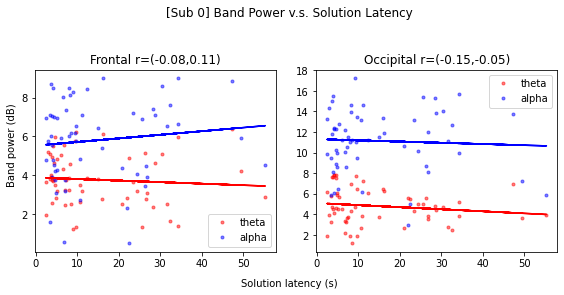

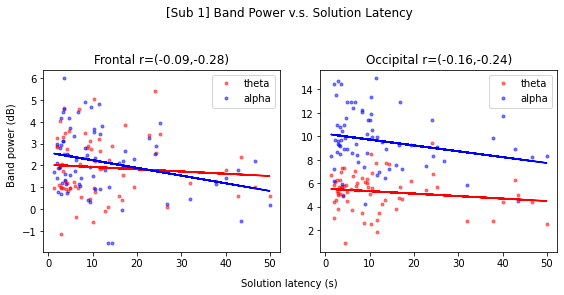

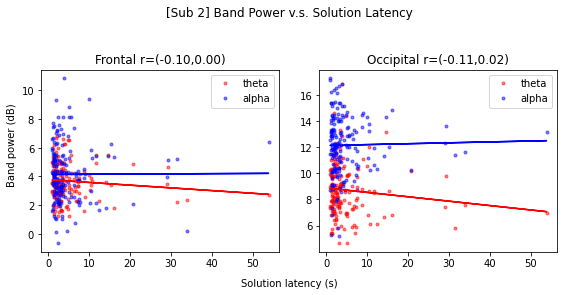

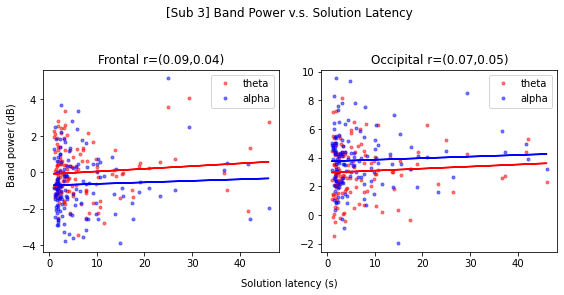

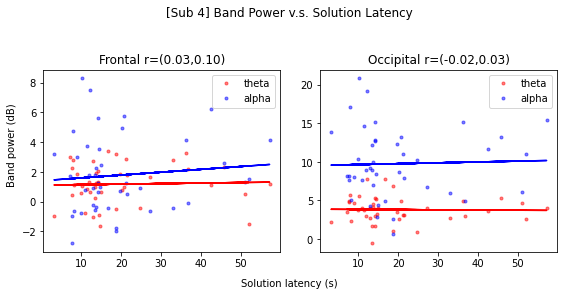

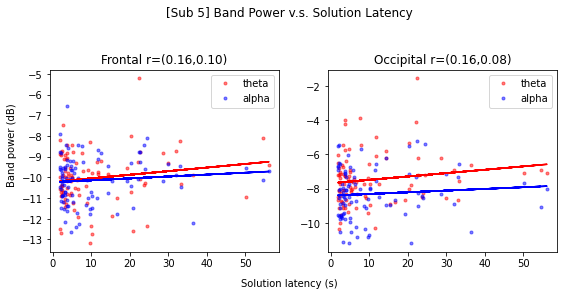

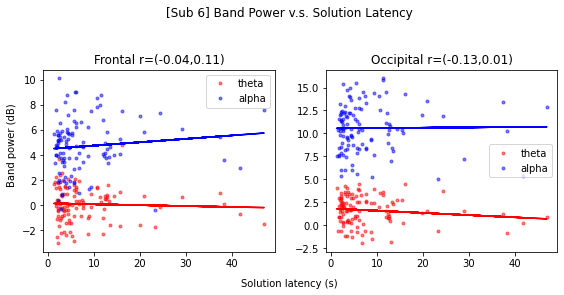

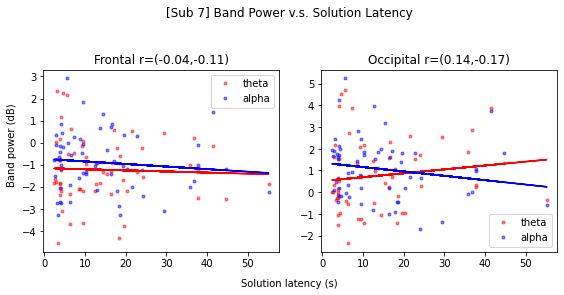

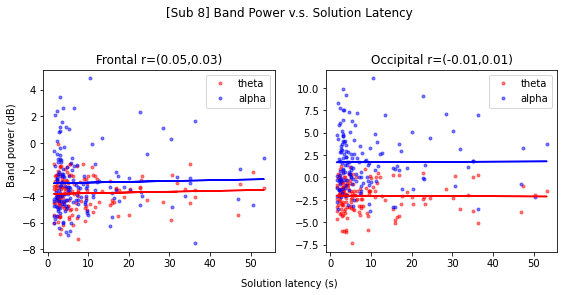

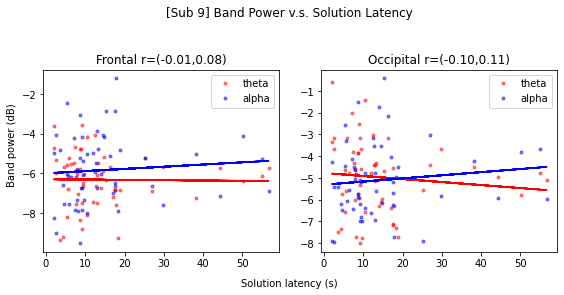

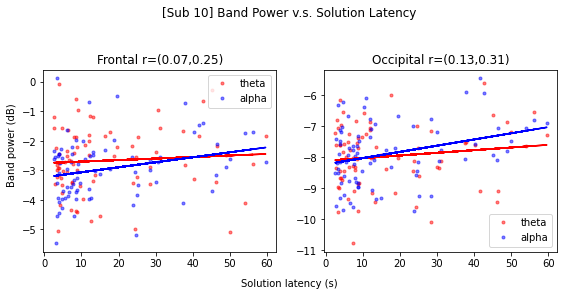

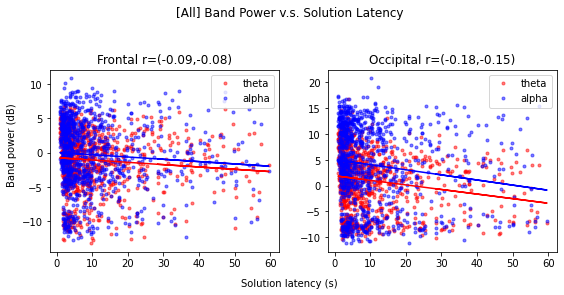

In [4]:
# Analyze each subject
rgr = LinearRegression()
for i_sub in range(len(np.unique(S))):
    sub_indices = np.where(S==i_sub)[0]
    Y_sub = Y[sub_indices]
    mean_fbp, mean_obp = {}, {}
    
    # Take mean power and conver into log scale
    for i_band, band in enumerate(['theta','alpha']):
        mean_fbp[band] = 10*np.log10(np.mean(frontal_bp[band][sub_indices,:], axis=1))
        mean_obp[band] = 10*np.log10(np.mean(occipital_bp[band][sub_indices,:], axis=1))
    
    # Plot 
    fig, axs = plt.subplots(1,2, figsize=(8,4))
    for i_plot, mean_bp in enumerate([mean_fbp, mean_obp]):
        axs[i_plot].plot(Y_sub, mean_bp['theta'],'r.', label='theta', alpha=0.5)
        axs[i_plot].plot(Y_sub, mean_bp['alpha'],'b.', label='alpha', alpha=0.5)
        
        rgr.fit(Y_sub.reshape((-1,1)), mean_bp['theta'])
        axs[i_plot].plot(Y_sub, Y_sub*rgr.coef_+rgr.intercept_, 'r-')
        rgr.fit(Y_sub.reshape((-1,1)), mean_bp['alpha'])
        axs[i_plot].plot(Y_sub, Y_sub*rgr.coef_+rgr.intercept_, 'b-')
        
        region = 'Frontal' if i_plot==0 else 'Occipital'
        SL_bp_coef = [np.corrcoef(Y_sub,mean_bp[band])[0,1] for band in ['theta','alpha']]
        axs[i_plot].set_title('%s r=(%.2f,%.2f)'%(region, SL_bp_coef[0], SL_bp_coef[1]))
        axs[i_plot].legend()
    
    fig.suptitle('[Sub %d] Band Power v.s. Solution Latency'%(i_sub))
    fig.text(0.5, 0.01, 'Solution latency (s)', ha='center')
    fig.text(0.01, 0.5, 'Band power (dB)', va='center', rotation='vertical')
    fig.tight_layout(pad=2.0)
    fig.savefig('./results/Analyze_high_stress/mod_bp_SL_sub%d.png'%(i_sub))
    
# Analyze all subjects
mean_fbp, mean_obp = {}, {}
    
# Take mean power and conver into log scale
for i_band, band in enumerate(['theta','alpha']):
    mean_fbp[band] = 10*np.log10(np.mean(frontal_bp[band], axis=1))
    mean_obp[band] = 10*np.log10(np.mean(occipital_bp[band], axis=1))

# Plot 
fig, axs = plt.subplots(1,2, figsize=(8,4))
for i_plot, mean_bp in enumerate([mean_fbp, mean_obp]):
    axs[i_plot].plot(Y, mean_bp['theta'],'r.', label='theta', alpha=0.5)
    axs[i_plot].plot(Y, mean_bp['alpha'],'b.', label='alpha', alpha=0.5)

    rgr.fit(Y.reshape((-1,1)), mean_bp['theta'])
    axs[i_plot].plot(Y, Y*rgr.coef_+rgr.intercept_, 'r-')
    rgr.fit(Y.reshape((-1,1)), mean_bp['alpha'])
    axs[i_plot].plot(Y, Y*rgr.coef_+rgr.intercept_, 'b-')

    region = 'Frontal' if i_plot==0 else 'Occipital'
    SL_bp_coef = [np.corrcoef(Y,mean_bp[band])[0,1] for band in ['theta','alpha']]
    axs[i_plot].set_title('%s r=(%.2f,%.2f)'%(region, SL_bp_coef[0], SL_bp_coef[1]))
    axs[i_plot].legend()

fig.suptitle('[All] Band Power v.s. Solution Latency')
fig.text(0.5, 0.01, 'Solution latency (s)', ha='center')
fig.text(0.01, 0.5, 'Band power (dB)', va='center', rotation='vertical')
fig.tight_layout(pad=2.0)
fig.savefig('./results/Analyze_high_stress/mod_bp_SL_all.png')
    

# Analyze the relationship between solution latency trend and solution latency of initial trial

<font size='4'>
Claim 2 ($\Delta$):
   
The subjects who spend longer time on initial trials have increasing SL due to increasing mental pressure. On the contrary, subjects who nail the initial trials have decreasing SL due to high confidence and low pressure.
    
Result: 
   


</font>

In [37]:
# Read solution latency sequentially

# Get list of data names
df_names = pd.read_csv('./Data_Matlab/data_list.csv')
data_names = [x[0:6] for x in df_names.values.flatten()]

fs = 256
SL_all = []
for i_file, fileName in enumerate(data_names):
    
    EEG = sio.loadmat('./Data_Python/%s_21.mat'%(fileName))
    events = EEG['event']
    
    SL_list = []
    for i_event in range(len(events)-1):
        # In event: [time, type]
        cur_event = events[i_event]
        next_event = events[i_event+1]
        
        if cur_event[1] in ['1','2','3'] and next_event[1]=='501':
            time = float(next_event[0]-cur_event[0])/fs
            if time<=60:
                SL_list.append(time)
            
    SL_all.append(np.array(SL_list))

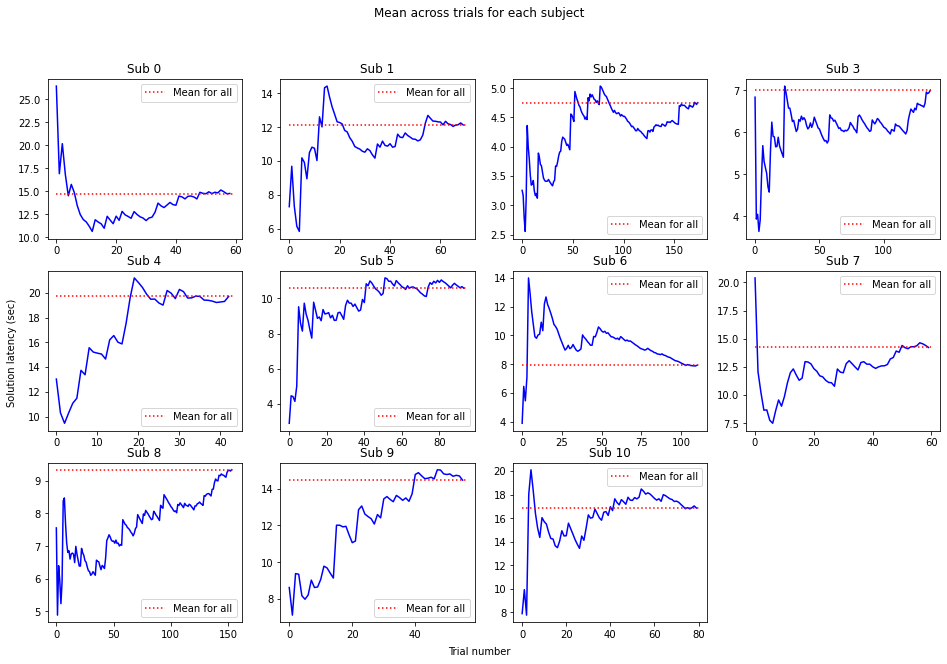

In [58]:
fig, axs = plt.subplots(3, 4, figsize=(16, 10))

for i_sub in range(11):
    SL_i = np.array(SL_all[i_sub])
    divisor = np.arange(len(SL_i))+1
    mean_trials = np.cumsum(SL_i)/divisor
    
    row, col = i_sub//4, i_sub%4
    axs[row,col].plot(mean_trials, 'b-')
    axs[row,col].plot([0,len(mean_trials)], [mean_trials[-1],mean_trials[-1]], 'r:', label='Mean for all')
    axs[row,col].set_title('Sub %d'%(i_sub))
    axs[row,col].legend()
    
axs[2,3].axis('off')

fig.text(0.5, 0.08, 'Trial number', ha='center')
fig.text(0.09, 0.5, 'Solution latency (sec)', va='center', rotation='vertical')
fig.suptitle('Mean across trials for each subject')
fig.savefig('./results/Analyze_SL_trialNo/mean_across_trial.png')

In [26]:
initial = []
last = []
mean_SL = []
for i_sub in range(11):
    num_trials_i = len(SL_all[i_sub])
    initial.append(np.mean(SL_all[i_sub][:int(num_trials_i/10)]))
    last.append(np.mean(SL_all[i_sub][-int(num_trials_i/10):]))
    mean_SL.append(np.mean(SL_all[i_sub]))
    print('Sub %d: Number of trials %d, Initial %.1f s, Last %.1f s, Mean %.1f s'
          %(i_sub, num_trials_i, initial[-1], last[-1], mean_SL[-1]))

Sub 0: Number of trials 59, Initial 14.5 s, Last 13.3 s, Mean 14.8 s
Sub 1: Number of trials 70, Initial 9.9 s, Last 10.2 s, Mean 12.1 s
Sub 2: Number of trials 174, Initial 3.9 s, Last 5.3 s, Mean 4.8 s
Sub 3: Number of trials 137, Initial 5.6 s, Last 12.0 s, Mean 7.0 s
Sub 4: Number of trials 43, Initial 10.3 s, Last 23.5 s, Mean 19.7 s
Sub 5: Number of trials 94, Initial 9.7 s, Last 8.5 s, Mean 10.6 s
Sub 6: Number of trials 111, Initial 10.0 s, Last 5.9 s, Mean 7.9 s
Sub 7: Number of trials 60, Initial 7.8 s, Last 13.6 s, Mean 14.2 s
Sub 8: Number of trials 154, Initial 6.8 s, Last 13.0 s, Mean 9.3 s
Sub 9: Number of trials 56, Initial 8.2 s, Last 11.4 s, Mean 14.5 s
Sub 10: Number of trials 80, Initial 15.2 s, Last 12.5 s, Mean 16.9 s


Text(0.5, 1.0, '10% v.s. Mean SL for each subject (r=0.68,0.78)')

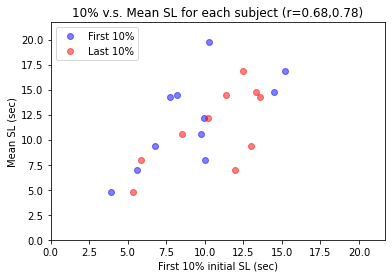

In [42]:
initial = np.array(initial)
mean_SL = np.array(mean_SL)
last = np.array(last)
max_value = max(np.max(initial), np.max(mean_SL))

plt.plot(initial, mean_SL, 'bo', last, mean_SL, 'ro', alpha=0.5)
plt.xlabel('First 10% initial SL (sec)')
plt.ylabel('Mean SL (sec)')
plt.xlim([0,max_value+2])
plt.ylim([0,max_value+2])
plt.legend(('First 10%', 'Last 10%'))
plt.title('10%% v.s. Mean SL for each subject (r=%.2f,%.2f)'%
          (np.corrcoef(initial, mean_SL)[0,1], np.corrcoef(last, mean_SL)[0,1]))

# Analyze pre-simulus alpha and theta power across trials

<font size="3">
Claim 3:
    
The theta and alpha power may raise due to fatigue. From the above test, most subjects have increasing solution latency as the trial increases. If the theta and alpha power also increase as trial increases, we may say that the increasing solution latency is caused by fatigue.
    
Result: 
    
There is no consistent trend showing that the theta and alpha power increases with the trials. Alpha power has larger variations than theta power most of the time. One interesting thing is that band power have similar trend in occipital and frontal both for theta and alpha.
</font>

In [18]:
def extract_data(data, events, rm_baseline):
    '''
    Extract baseline data and solution time

    Parameters
    ----------
    data : numpy 2D array (j, k)
        j : channel
        k : sample
    events : numpy 2D array
        event time and type
    rm_baseline : bool
        Remove baseline before fixation

    Returns
    -------
    X : numpy 3D array (i, j, k)
        i : example
        j : channel
        k : sample
    Y : numpy 1D array
        solution latency of example
    '''
    assert isinstance(rm_baseline, bool)
    
    sampling_rate = 256
    time_baseline = int(sampling_rate/2)
    X = []
    Y = []
    
    for i in range(len(events)-1):
        # In event : [time, type]
        cur_event = events[i]
        next_event = events[i+1]
        cur_time = int(cur_event[0])
        
        if cur_event[1] in ['1','2','3'] and next_event[1] == '501':
            time = float((next_event[0] - cur_time)/sampling_rate)
            if time < 60:
                X.append(data[:, cur_time-2*sampling_rate+1:cur_time+1])
                if rm_baseline:
                    baseline = np.mean(data[:, cur_time-int(2.5*sampling_rate):cur_time-int(2*sampling_rate)], axis=1)
                    X[-1] -= baseline[:,np.newaxis] 

                Y.append(time)
          
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

In [8]:
frontal = ['Fp1','Fp2','F3','Fz','F4']
occipital = ['O1', 'Oz', 'O2']

# Get list of data names
df_names = pd.read_csv('./Data_Matlab/data_list.csv')
data_names = [x[0:6] for x in df_names.values.flatten()]

fs = 256
SL_all = []
bp_all = {'front':[], 'occip':[]}
for i_file, fileName in enumerate(data_names):
    
    EEG = sio.loadmat('./Data_Python/%s_21.mat'%(fileName))
    events = EEG['event']
    data = EEG['data']
    chanlocs = EEG['chanlocs']
    
    # Select frontal and occipital data
    channel_labels = np.array([chanlocs['labels'][0,i][0] for i in range(21)])
    i_frontal = [int(np.where(channel_labels==frontal[i])[0]) for i in range(len(frontal))]
    i_occipital = [int(np.where(channel_labels==occipital[i])[0]) for i in range(len(occipital))]
    
    front_data = data[i_frontal,:]
    occip_data = data[i_occipital,:]
    
    # Extract pre-stimulus data and solution latency
    front_pre_data, SL_i = extract_data(front_data, events, True)
    occip_pre_data, _ = extract_data(occip_data, events, True)
    SL_all.append(SL_i)
    
    # Transform time signal into band power
    low, high = [4,7], [7,13]    # theta, alpha
    bp_all['front'].append(bandpower.get_bandpower(front_pre_data, low=low, high=high))
    bp_all['occip'].append(bandpower.get_bandpower(occip_pre_data, low=low, high=high))

Calculating the bandpower of time-series data...
Calculating the bandpower of time-series data...
Calculating the bandpower of time-series data...
Calculating the bandpower of time-series data...
Calculating the bandpower of time-series data...
Calculating the bandpower of time-series data...
Calculating the bandpower of time-series data...
Calculating the bandpower of time-series data...
Calculating the bandpower of time-series data...
Calculating the bandpower of time-series data...
Calculating the bandpower of time-series data...
Calculating the bandpower of time-series data...
Calculating the bandpower of time-series data...
Calculating the bandpower of time-series data...
Calculating the bandpower of time-series data...
Calculating the bandpower of time-series data...
Calculating the bandpower of time-series data...
Calculating the bandpower of time-series data...
Calculating the bandpower of time-series data...
Calculating the bandpower of time-series data...
Calculating the band

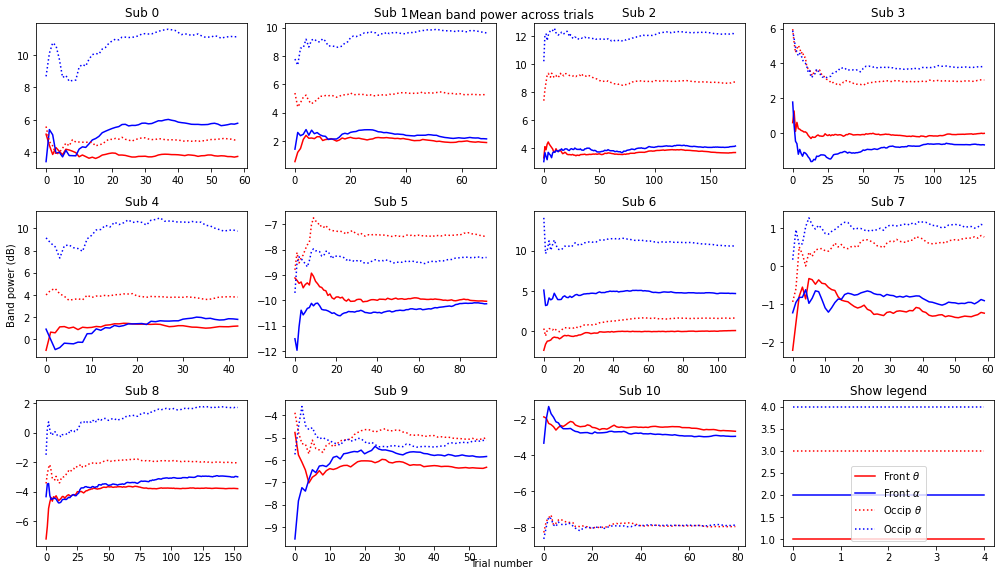

In [30]:
fig, axs = plt.subplots(3,4, figsize=(14,8))

for i_sub in range(11):
    
    mean_front_power = 10*np.log10(np.mean(bp_all['front'][i_sub], axis=1))
    mean_occip_power = 10*np.log10(np.mean(bp_all['occip'][i_sub], axis=1))
    #mean_front_power = np.mean(bp_all['front'][i_sub], axis=1)
    #mean_occip_power = np.mean(bp_all['occip'][i_sub], axis=1)
                               
    divisor = np.arange(len(bp_all['front'][i_sub]))+1
    
    row, col = i_sub//4, i_sub%4
    axs[row,col].plot(np.cumsum(mean_front_power[:,0])/divisor, 'r-', 
                       np.cumsum(mean_front_power[:,1])/divisor, 'b-',
                       np.cumsum(mean_occip_power[:,0])/divisor, 'r:',
                       np.cumsum(mean_occip_power[:,1])/divisor, 'b:')
    axs[row,col].set_title('Sub %d'%(i_sub))
    
# Plot legend
line = np.zeros(5)
axs[2,3].plot(line+1, 'r-', line+2, 'b-', line+3, 'r:', line+4, 'b:')
axs[2,3].legend((r'Front $\theta$', r'Front $\alpha$', r'Occip $\theta$', r'Occip $\alpha$'))
axs[2,3].set_title('Show legend')

fig.tight_layout(pad=1.0)
fig.text(0.5, 0.01, 'Trial number', ha='center')
fig.text(0.01, 0.5, 'Band power (dB)', va='center', rotation='vertical')
fig.suptitle('Mean band power across trials')
fig.savefig('./results/Analyze_bp_trialNo/logbp_trials.png')

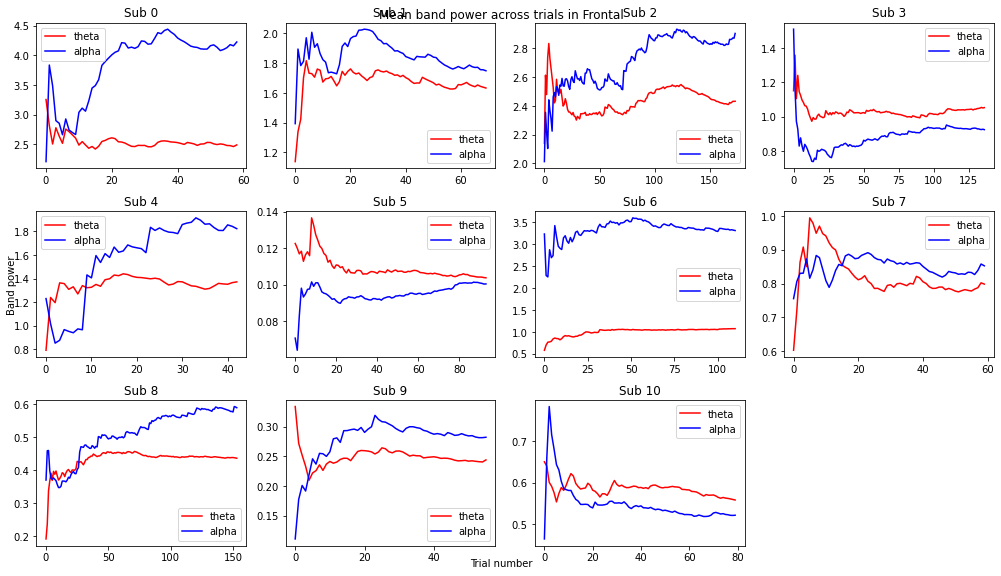

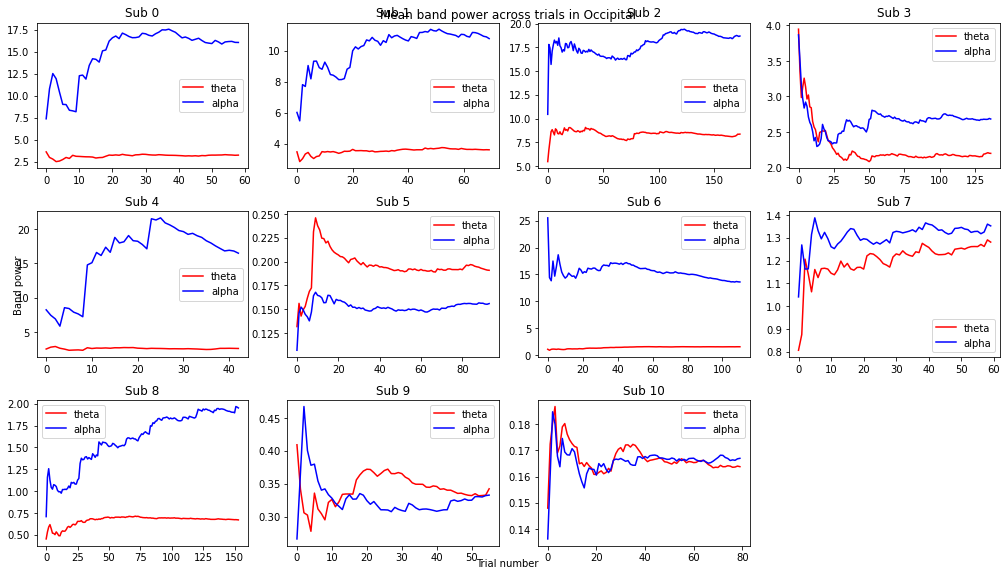

In [24]:
fig1, axs1 = plt.subplots(3,4, figsize=(14,8))
fig2, axs2 = plt.subplots(3,4, figsize=(14,8))

for i_sub in range(11):
    
    #mean_front_power = 10*np.log10(np.mean(bp_all['front'][i_sub], axis=1))
    #mean_occip_power = 10*np.log10(np.mean(bp_all['occip'][i_sub], axis=1))
    mean_front_power = np.mean(bp_all['front'][i_sub], axis=1)
    mean_occip_power = np.mean(bp_all['occip'][i_sub], axis=1)
                               
    divisor = np.arange(len(bp_all['front'][i_sub]))+1
    
    row, col = i_sub//4, i_sub%4
    axs1[row,col].plot(np.cumsum(mean_front_power[:,0])/divisor, 'r-', 
                       np.cumsum(mean_front_power[:,1])/divisor, 'b-')
    axs1[row,col].legend(('theta', 'alpha'))
    axs1[row,col].set_title('Sub %d'%(i_sub))
    
    axs2[row,col].plot(np.cumsum(mean_occip_power[:,0])/divisor, 'r-', 
                       np.cumsum(mean_occip_power[:,1])/divisor, 'b-')
    axs2[row,col].legend(('theta', 'alpha'))
    axs2[row,col].set_title('Sub %d'%(i_sub))
    
axs1[2,3].axis('off')
fig1.tight_layout(pad=1.0)
fig1.text(0.5, 0.01, 'Trial number', ha='center')
fig1.text(0.01, 0.5, 'Band power', va='center', rotation='vertical')
fig1.suptitle('Mean band power across trials in Frontal')
fig1.savefig('./results/Analyze_bp_trialNo/bp_trials_frontal.png')


axs2[2,3].axis('off')
fig2.tight_layout(pad=1.0)
fig2.text(0.5, 0.01, 'Trial number', ha='center')
fig2.text(0.01, 0.5, 'Band power', va='center', rotation='vertical')
fig2.suptitle('Mean band power across trials in Occipital')
fig2.savefig('./results/Analyze_bp_trialNo/bp_trials_occipital.png')